## Task 1: Exploratory Data Analysis (EDA) of Financial News

This notebook performs Task 1 of the project:
- Descriptive statistics of news headlines
- Text preprocessing and cleaning
- Time series analysis of news publication
- Publisher analysis


In [5]:
# -----------------------------
#  Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent  # Notebook/ -> project root
src_path = project_root / "src"

# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\notebooks
Project root: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment
SRC path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\src


### Imports


In [6]:
# Cell 1: Notebook bootstrap & imports
# ---------------------------------------------------------
# Setup paths, config, logger
from fns_project.utils.notebook_bootstrap import (
    cfg, logger, RAW_DIR, INTERIM_DIR, PROCESSED_DIR, FEATURE_DIR, PLOTS_DIR,
    ASSETS, START_DATE, END_DATE
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fns_project.data.loader import load_news, load_prices
from fns_project.data.preprocess import clean_text, preprocess_headlines, add_headline_metrics
from fns_project.utils.dates import normalize_timestamps
from fns_project.data.align_dates import align_news_to_trading_days, aggregate_headlines
from fns_project.viz.plots import plot_headline_lengths, plot_top_publishers, plot_publication_times
sns.set(style="whitegrid")

In [7]:
# -----------------------------
# Cell 3: Load input data
# -----------------------------
RAW_DIR = (project_root / "data/raw").resolve()
news_file = RAW_DIR / "news" / "raw_analyst_ratings.csv"
price_file = RAW_DIR / "prices" / f"{ASSETS[0]}.csv"

logger.info(f"Using news file: {news_file}")
logger.info(f"Using price file: {price_file}")

news_df = load_news(news_file)
price_df = load_prices(price_file)
logger.info("Data loading complete")

news_df.tail(5)

2025-11-26 16:14:18,992 [INFO] notebook: Using news file: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\news\raw_analyst_ratings.csv
2025-11-26 16:14:19,130 [INFO] notebook: Using price file: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\AAPL.csv
2025-11-26 16:14:47,179 [WARNING] fns_project.data.loader: Dropped 1351341 news rows with unparsable date
2025-11-26 16:14:47,245 [INFO] fns_project.data.loader: Loaded news (55987 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\news\raw_analyst_ratings.csv
2025-11-26 16:14:47,308 [INFO] fns_project.data.loader: Loaded prices (3774 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\raw\prices\AAPL.csv
2025-11-26 16:14:47,316 [INFO] notebook: Data loading complete


,Unnamed: 0,headline,url,publisher,date,stock
55982,1044115,7 Stocks Moving In Thursday's After-Hours Session,https://www.benzinga.com/news/20/06/16237924/7...,Tyree Gorges,2020-06-11 16:49:41-04:00,PVH
55983,1363985,"Financials, Energy Among Worst-Hit Sectors In ...",https://www.benzinga.com/news/20/06/16238109/f...,JJ Kinahan,2020-06-11 16:51:33-04:00,WMT
55984,1275136,"Twitter Removes About 174,000 China-Linked Acc...",https://www.benzinga.com/tech/20/06/16238284/t...,Benzinga Newsdesk,2020-06-11 17:01:39-04:00,TWTR
55985,985369,PG&E Corp Reports CPUC Approved Co.'s Microgri...,https://www.benzinga.com/news/20/06/16238398/p...,Benzinga Newsdesk,2020-06-11 17:11:20-04:00,PCG
55986,1350029,Quicken Loans Plans To IPO: Report,https://www.benzinga.com/news/20/06/16238300/q...,Jason Shubnell,2020-06-11 17:12:35-04:00,WFC


In [8]:
# Normalize timestamps to UTC
news_df = normalize_timestamps(
    news_df, date_col="date", original_tz="Etc/GMT+4", target_tz="UTC")
price_df = normalize_timestamps(price_df, date_col="date", target_tz="UTC")

2025-11-26 16:14:47,672 [INFO] fns_project.utils.dates: Normalized 'date' timestamps to UTC (rows=55987)
2025-11-26 16:14:47,891 [INFO] fns_project.utils.dates: Normalized 'date' timestamps to UTC (rows=3774)


In [9]:
# Row counts, null counts
news_df.info()
news_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55987 entries, 0 to 55986
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Unnamed: 0  55987 non-null  int64              
 1   headline    55987 non-null  object             
 2   url         55987 non-null  object             
 3   publisher   55987 non-null  object             
 4   date        55987 non-null  datetime64[ns, UTC]
 5   stock       55987 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(1), object(4)
memory usage: 2.6+ MB


Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [10]:
# Step 1: clean/normalize the headlines
news_df = preprocess_headlines(news_df, text_col="headline")

# Step 2: compute headline metrics (lengths, word counts, etc.)
news_df = add_headline_metrics(news_df)
news_df.tail(5)

2025-11-26 16:14:51,471 [INFO] fns_project.data.preprocess: Added headline metrics to 55987 rows


,Unnamed: 0,headline,url,publisher,date,stock,headline_len_chars,headline_word_count,headline_char_per_word
55982,1044115,7 stocks moving thursday hours session,https://www.benzinga.com/news/20/06/16237924/7...,Tyree Gorges,2020-06-11 20:49:41+00:00,PVH,38,6,6.333333
55983,1363985,financials energy among worst hit sectors bigg...,https://www.benzinga.com/news/20/06/16238109/f...,JJ Kinahan,2020-06-11 20:51:33+00:00,WMT,80,12,6.666667
55984,1275136,twitter removes 174 000 china linked accounts ...,https://www.benzinga.com/tech/20/06/16238284/t...,Benzinga Newsdesk,2020-06-11 21:01:39+00:00,TWTR,111,16,6.937500
55985,985369,pg e corp reports cpuc approved co microgrid p...,https://www.benzinga.com/news/20/06/16238398/p...,Benzinga Newsdesk,2020-06-11 21:11:20+00:00,PCG,54,9,6.000000
55986,1350029,quicken loans plans ipo report,https://www.benzinga.com/news/20/06/16238300/q...,Jason Shubnell,2020-06-11 21:12:35+00:00,WFC,30,5,6.000000


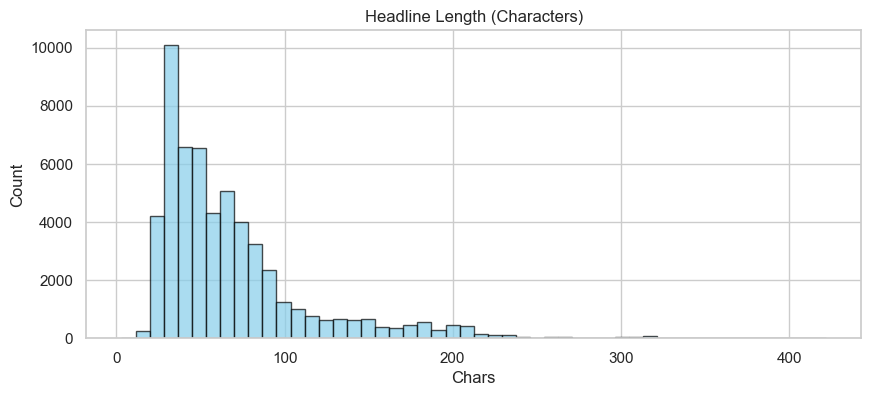

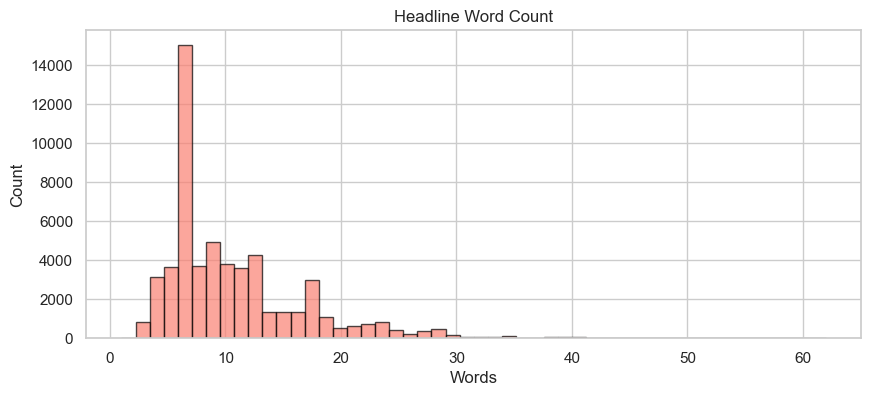

In [11]:
plot_headline_lengths(news_df)

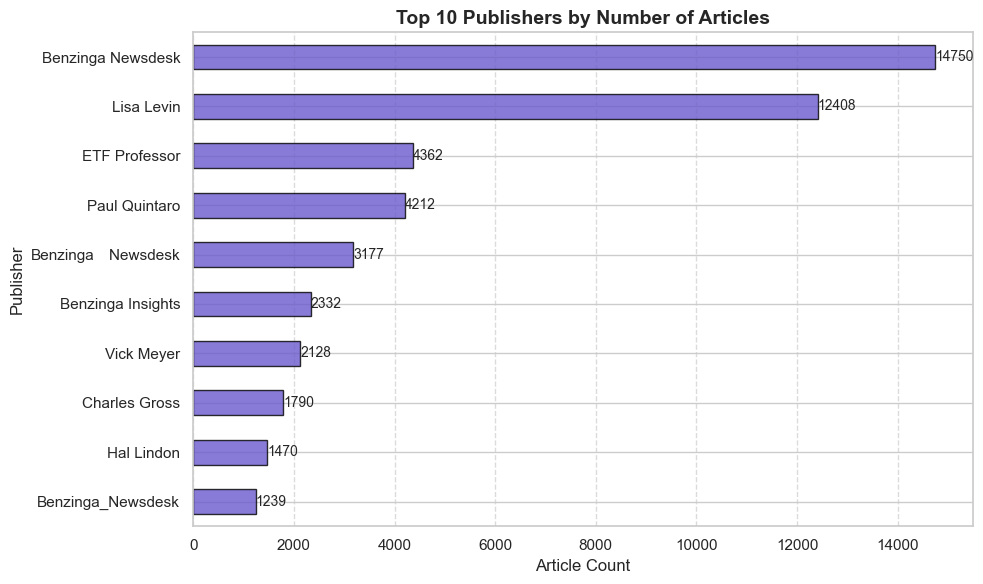

In [12]:
plot_top_publishers(news_df, top_n=10)

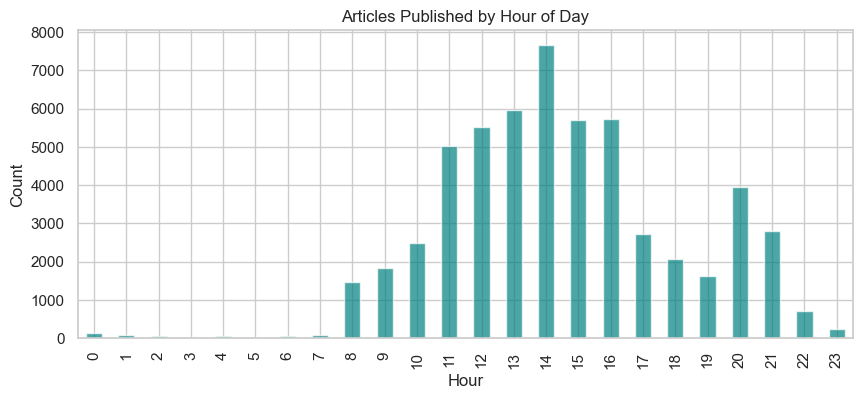

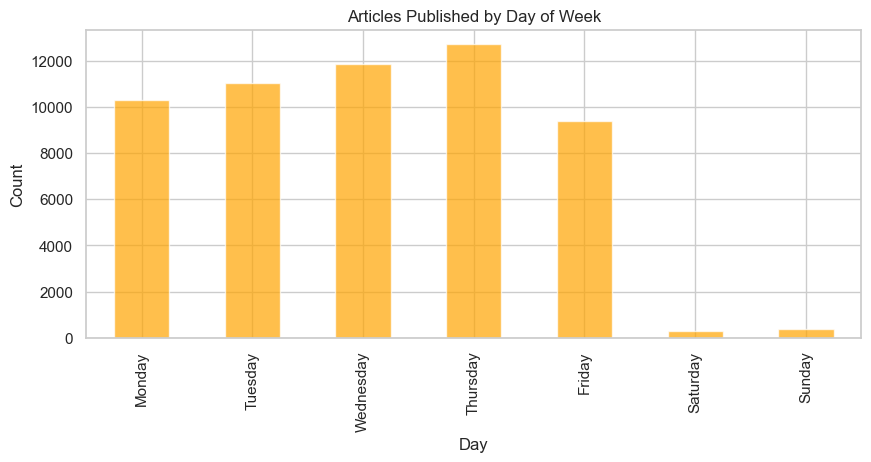

In [13]:
plot_publication_times(news_df, date_col="date")

In [14]:
news_aligned = align_news_to_trading_days(news_df, price_df)
news_agg = aggregate_headlines(news_aligned, group_by_cols=["trading_date"])

logger.info(f"Aggregated {len(news_agg)} trading-date news groups")

2025-11-26 16:14:57,604 [INFO] fns_project.data.align_dates: Aligned 55987 news rows to trading calendar (map_rule=next).
2025-11-26 16:14:57,885 [INFO] notebook: Aggregated 2225 trading-date news groups


In [16]:
INTERIM_DIR = project_root / "data" / "interim" / "news"
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

news_clean_file = INTERIM_DIR / "news_clean.csv"
news_agg.to_csv(news_clean_file, index=False)
logger.info(f"Saved cleaned news to {news_clean_file}")

2025-11-26 16:18:53,389 [INFO] notebook: Saved cleaned news to D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\interim\news\news_clean.csv


### Interpretation:

-Articles peak during working hours (11  – 16 ), aligning with business news cycles.

- Weekdays have more articles than weekends, consistent with market-focused reporting.

### Summary for Task 1

- Headlines are mostly concise—ideal for sentiment extraction.

- Article distribution is skewed toward a few publishers; these may bias overall sentiment.

- Publication timing aligns with market hours, which is useful for aligning news with price movements.